In [ ]:
import os
from json import loads, dumps
files = os.listdir('data/qmt-cirq-permutations/exec-metadata/');

In [ ]:
def key_fn(el):
    for key in el:
        return el[key]['divergence_from_cirq']['statistic']

def most_deviant_config():
    res = {}
    for file in files:
        content = loads( open( 'data/qmt-cirq-permutations/exec-metadata/' + file ).read() )
        subset_metadata = content['subset_metadata']
        
        res[file] = max(subset_metadata, key=key_fn)
    return res


res = most_deviant_config()

In [ ]:
from executor import execute_single_py_program, detect_divergence
from transpiler import CirqCircuit
from utils import get_qiskit_content_by_program_id
import re
from copy import deepcopy

final_res = {}

for key in res:
    filename = key.split('.')[0]

    for k in res[key]:
        perm = deepcopy(res[key][k]['perm'])
        perm.remove('expand_composite')

    qiskit_src = get_qiskit_content_by_program_id(filename)

    instrumented_qiskit_source = re.sub(
            r"qc.append\(C3XGate\(.*\)", "\n", qiskit_src
        )
    cirq = CirqCircuit(instrumented_qiskit_source)
    
    _, non_optimized_src = cirq.get_follow_up({ "add_unitary": False })
    
    non_opt_dist, _ = execute_single_py_program(non_optimized_src)
    
    _, cirq_src = cirq.get_follow_up(config={ "transformations": perm, "add_unitary": False })
    
    one_res = []
    for _ in range(30):
        dist, _ = execute_single_py_program(
                instrumented_qiskit_source
            )
        one_res.append(detect_divergence({"res_A": non_opt_dist,"res_B": dist}))
    final_res[filename] = one_res

final_res

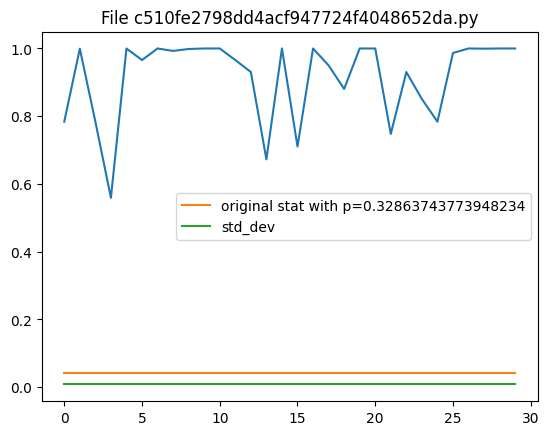

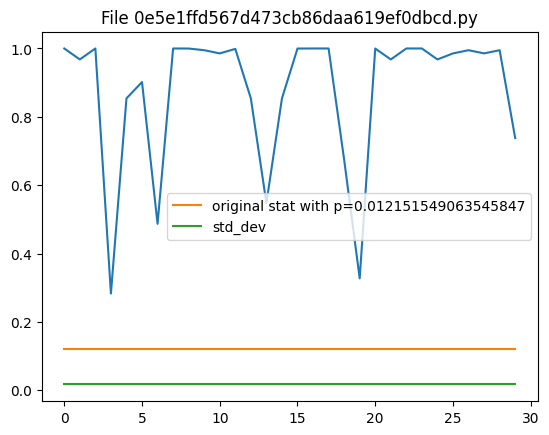

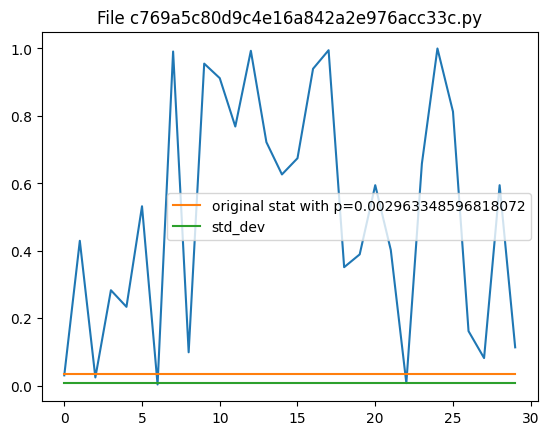

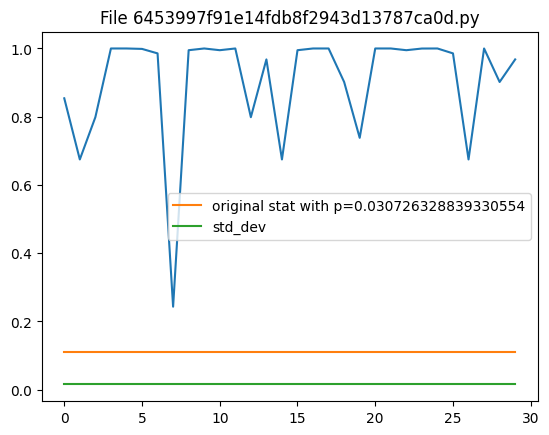

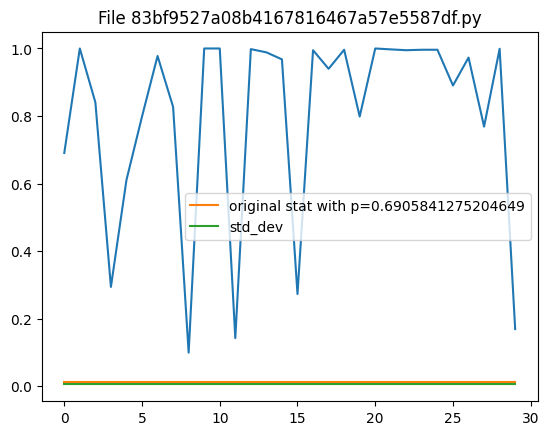

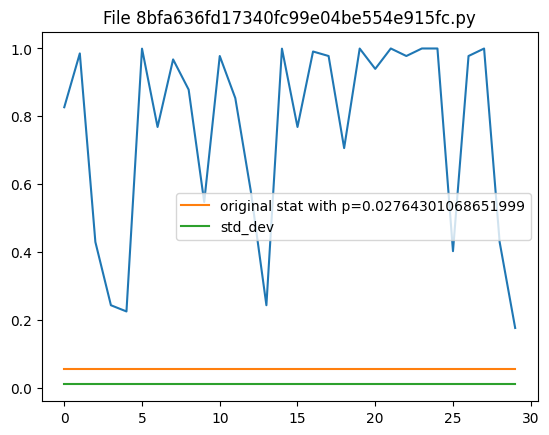

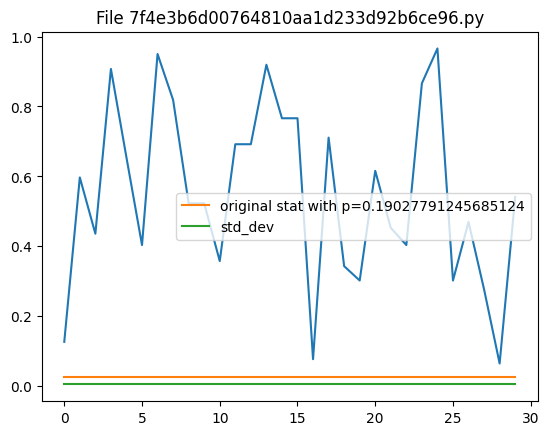

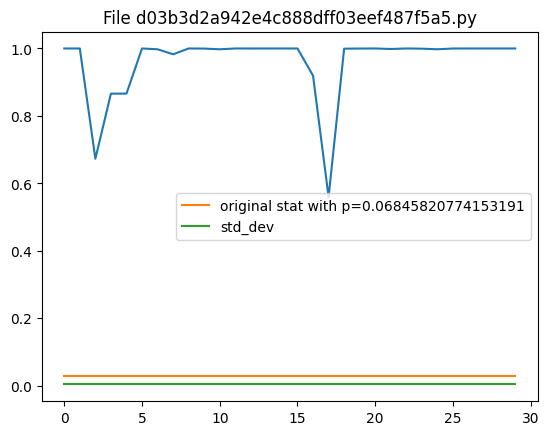

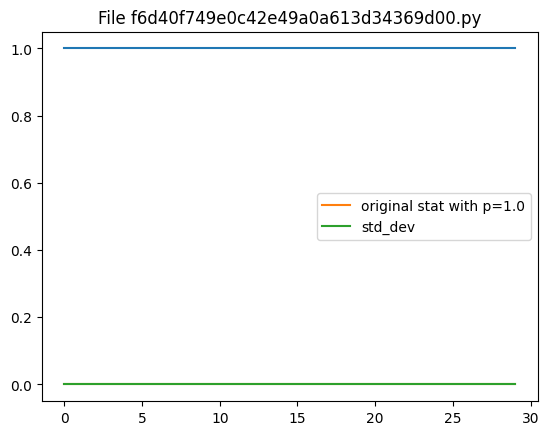

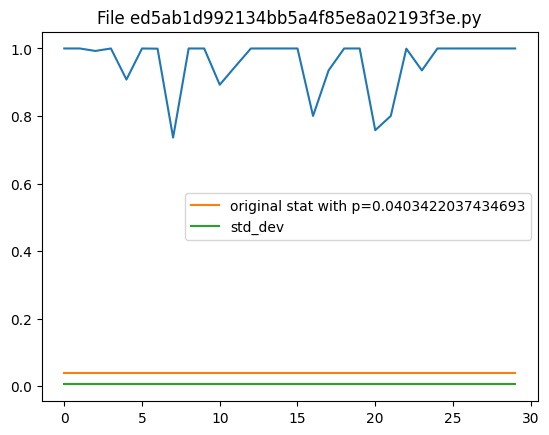

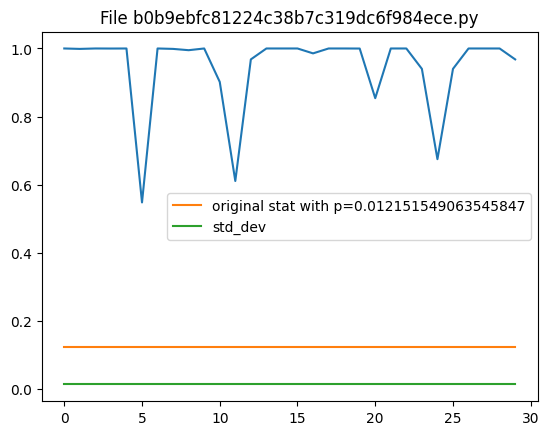

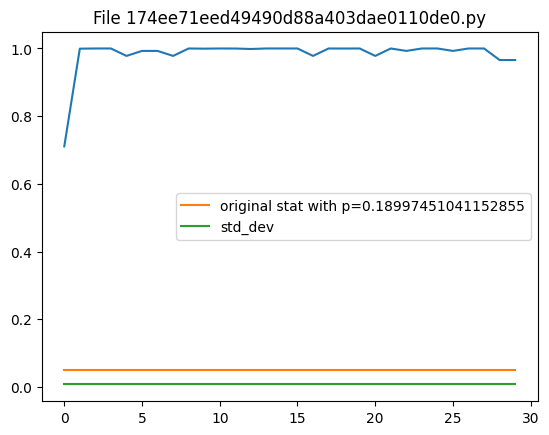

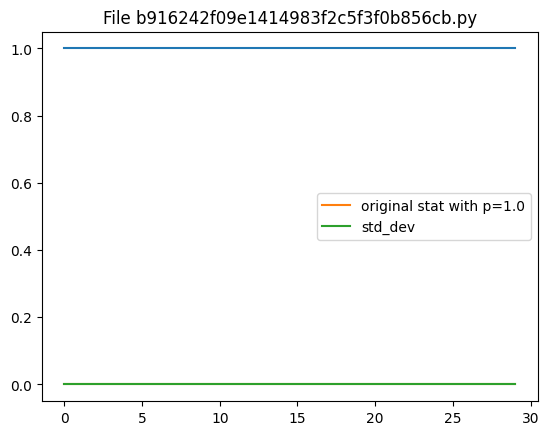

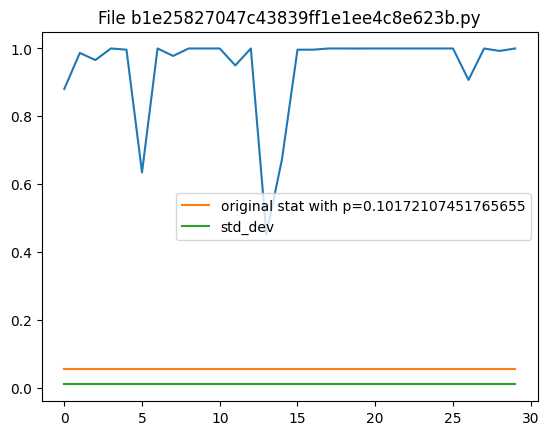

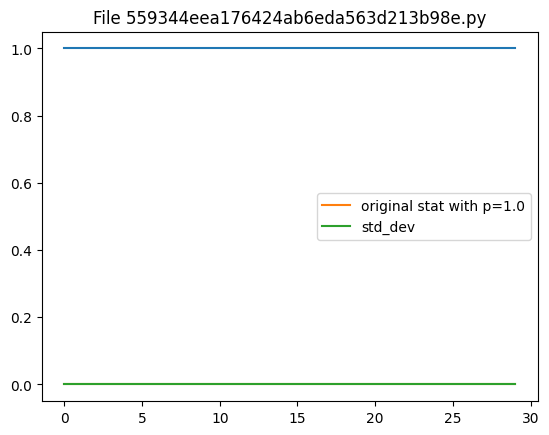

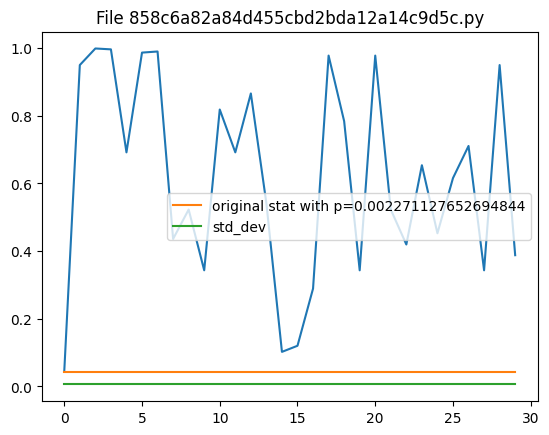

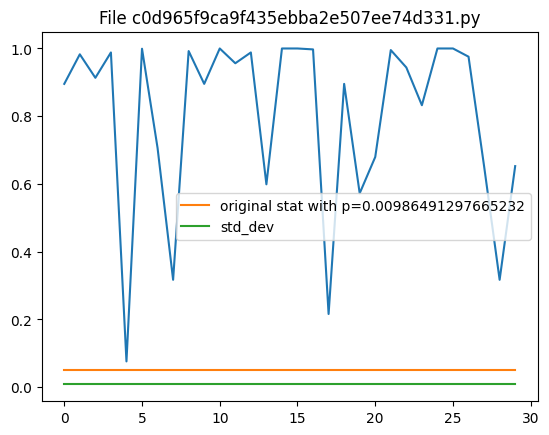

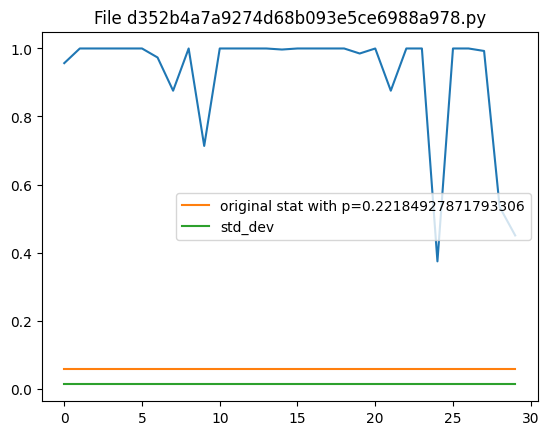

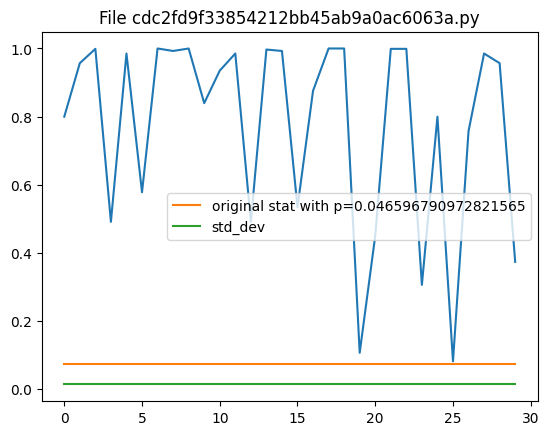

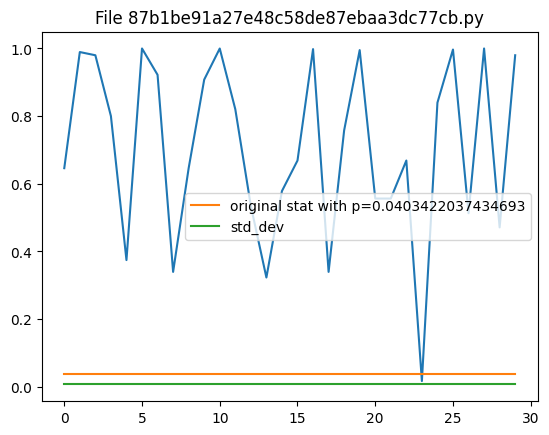

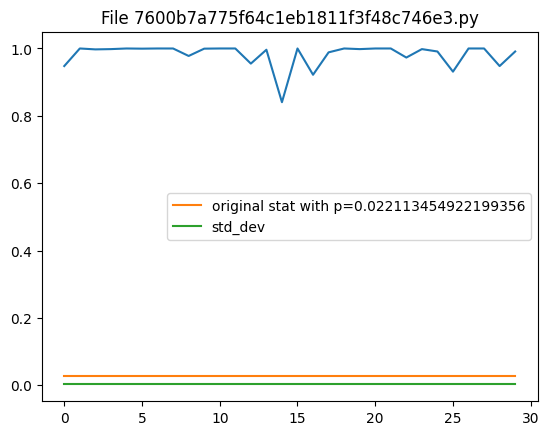

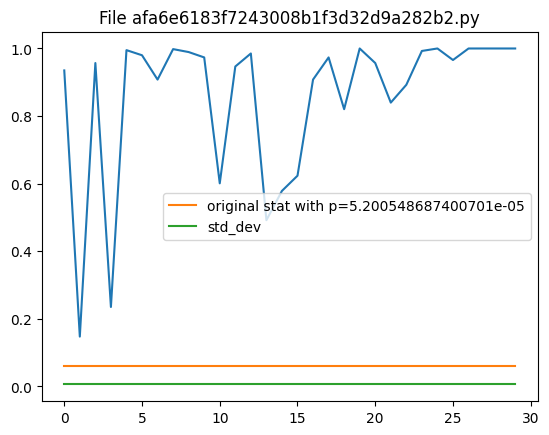

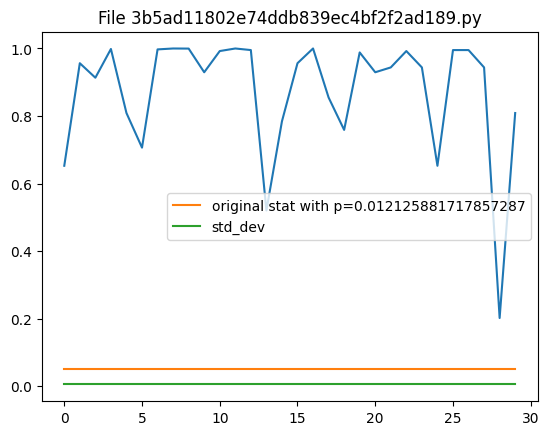

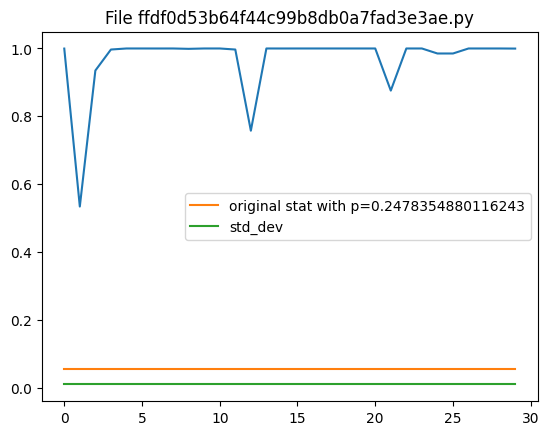

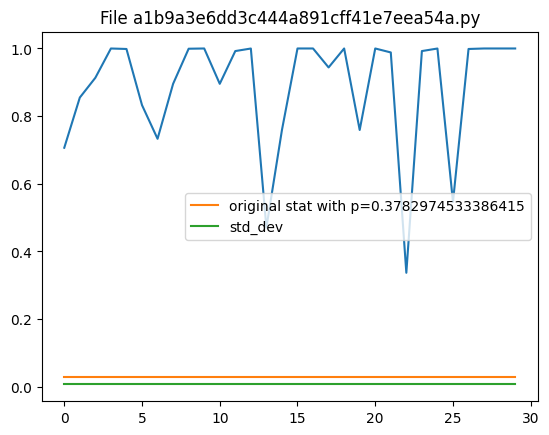

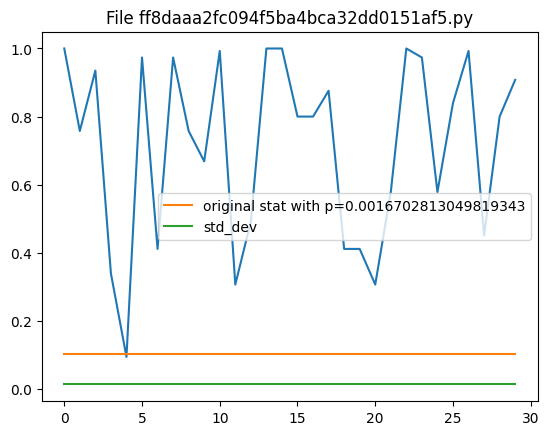

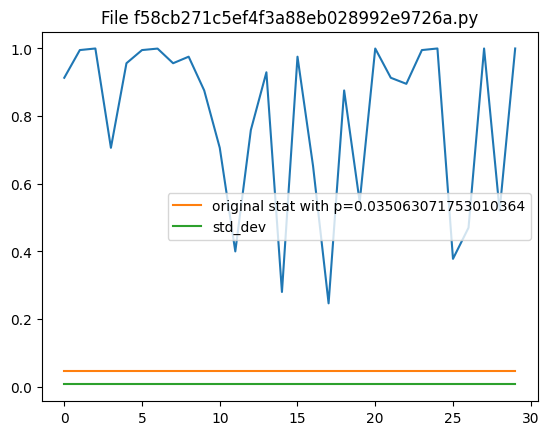

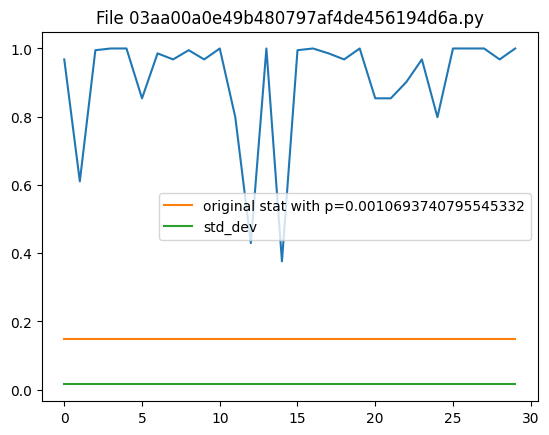

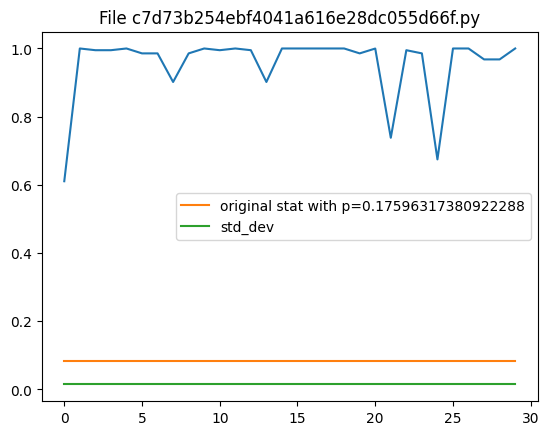

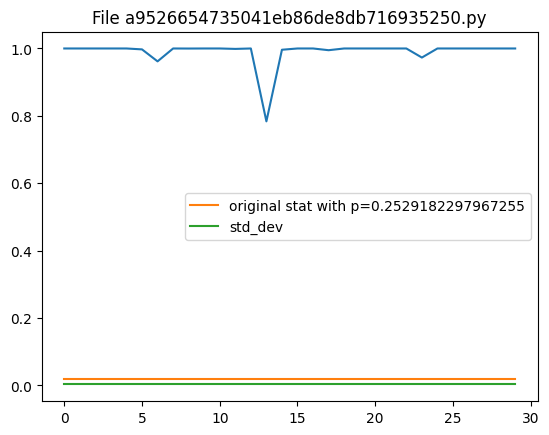

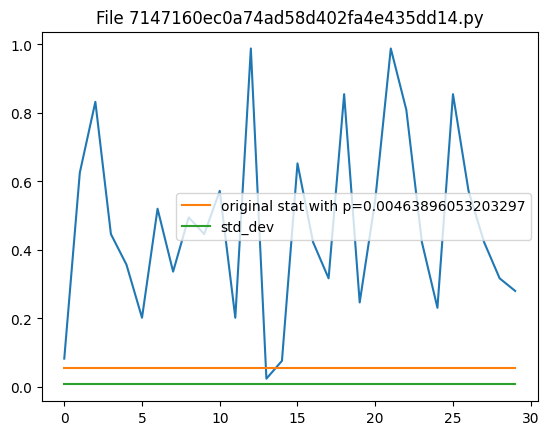

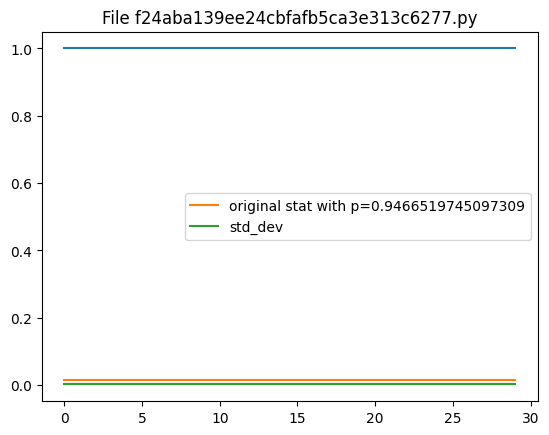

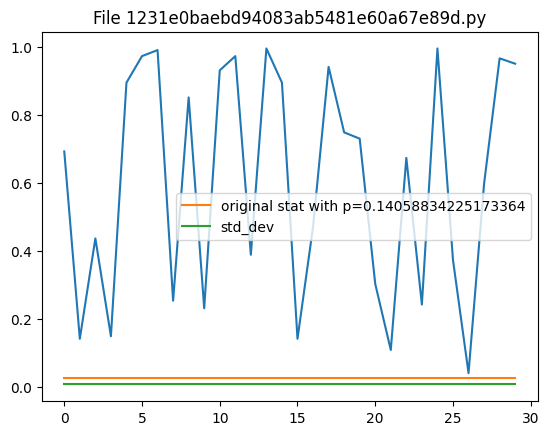

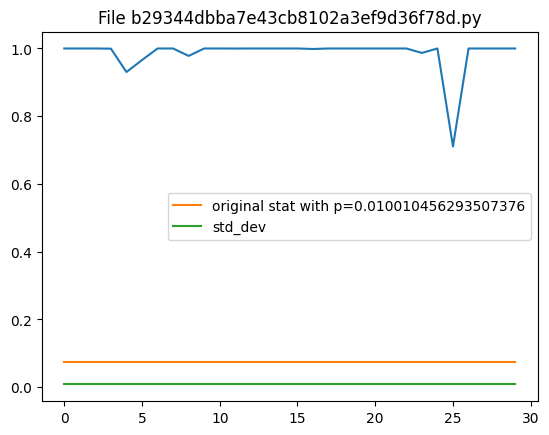

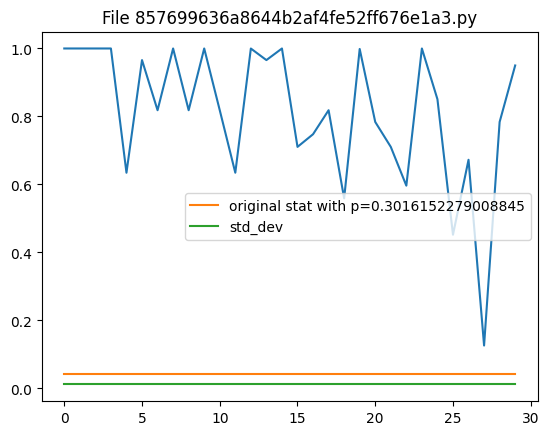

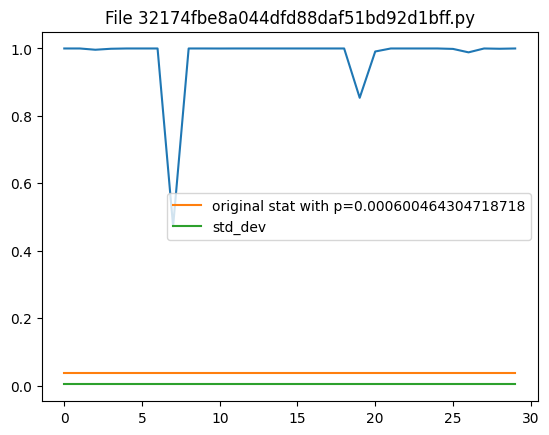

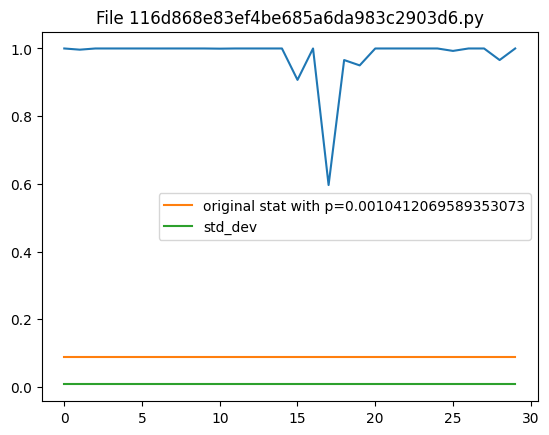

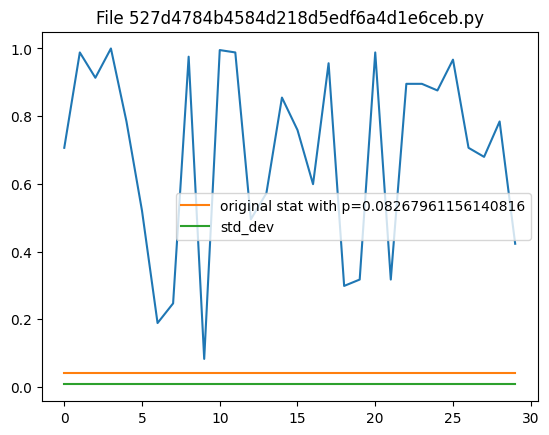

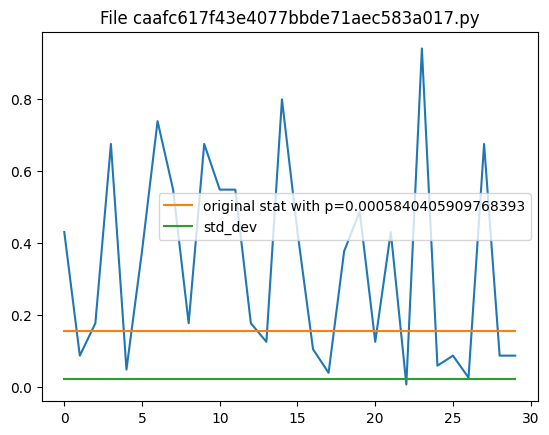

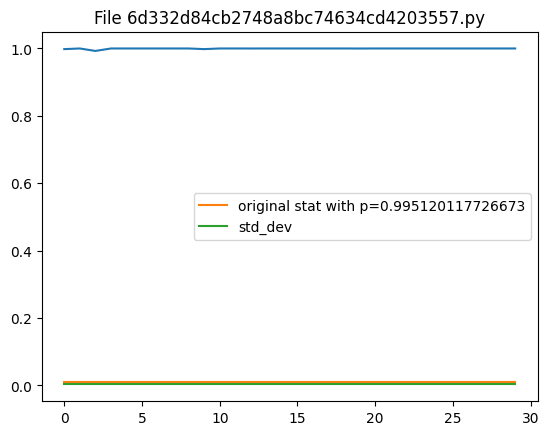

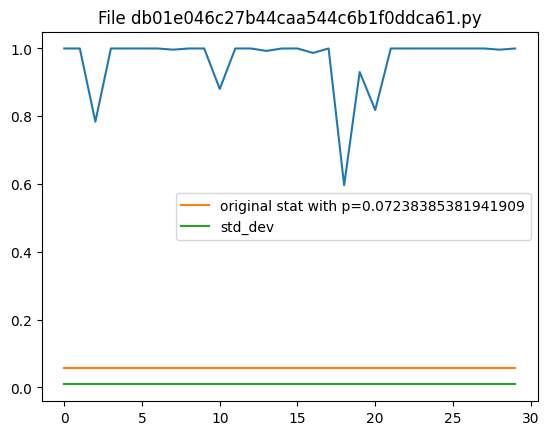

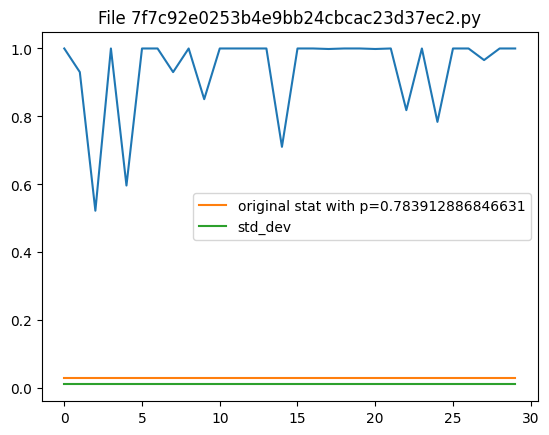

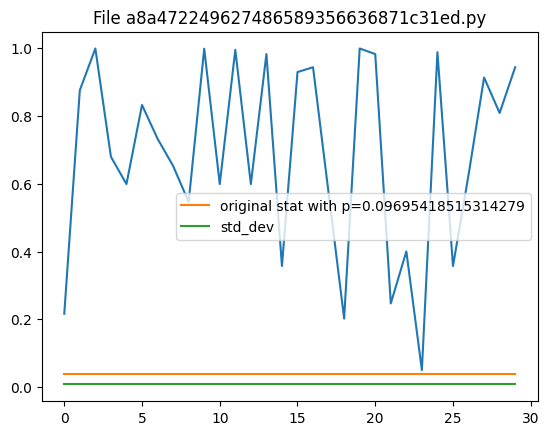

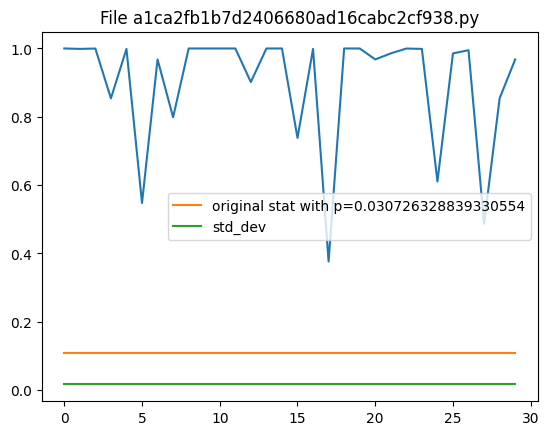

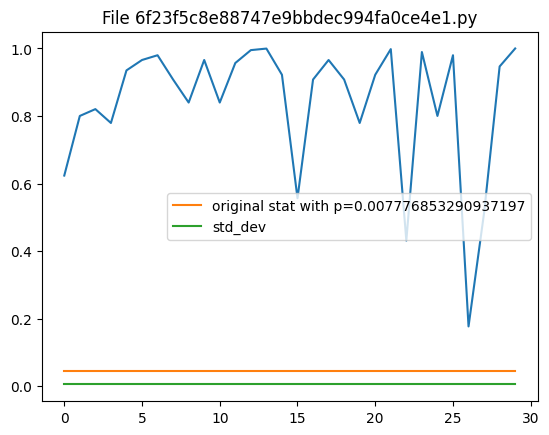

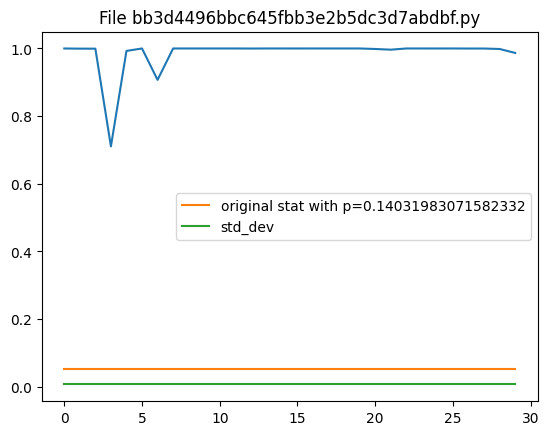

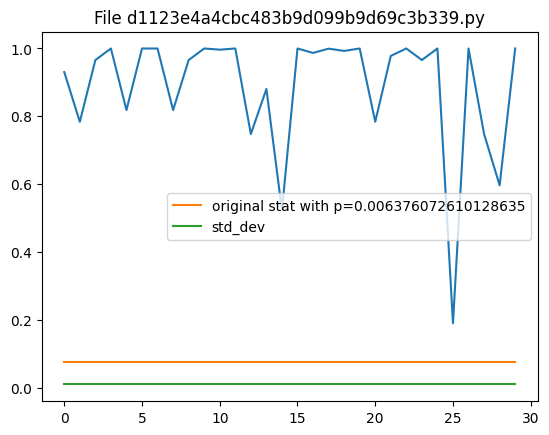

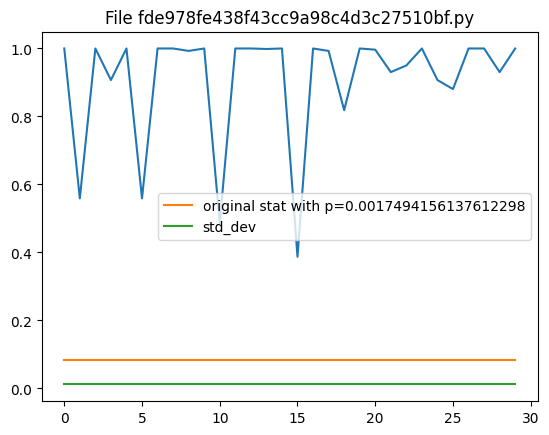

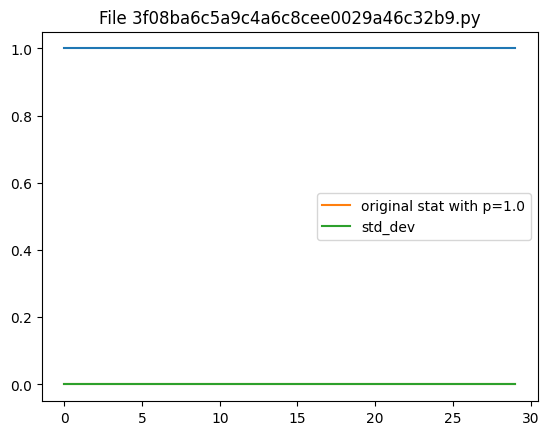

In [31]:
import numpy as np
import matplotlib.pylab as plt

def std_dev():
    for k in final_res:
        arr = final_res[k]
        stats = [ el['statistic'] for el in arr ]
        ps = [ el['p-value'] for el in arr ]
        sd = np.std(stats)
        
        for x in res[k+'.json']:
            orig_stat = res[k+'.json'][x]['divergence_from_qiskit']['statistic']
            orig_p = res[k+'.json'][x]['divergence_from_qiskit']['p-value']
        
        # plt.plot(stats)
        plt.plot(ps)
        plt.plot([orig_stat] * len(stats), label=f"original stat with p={orig_p}")
        plt.plot([sd] * len(stats), label="std_dev")
        plt.legend(loc="center right")
        plt.title(f"File {k}.py")
        plt.show()
        # break

std_dev()